## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

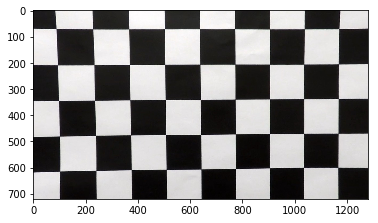

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

def calibrate():    
    images = glob.glob('../camera_cal/calibration*.jpg')
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
            
    return objpoints, imgpoints


def cal_undistort_coeff(objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img = mpimg.imread('../camera_cal/calibration1.jpg')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist


g_objpoints, g_imgpoints = calibrate()
g_mtx, g_dist = cal_undistort_coeff(g_objpoints, g_imgpoints)

def undist_img_for_img(img):
    global g_mtx
    global g_dist
    dst = cv2.undistort(img, g_mtx, g_dist, None, g_mtx)
    undist = np.copy(dst) 
    return undist

def undist_img(path):
    img = mpimg.imread(path)
    return undist_img_for_img(img)
    
def test_undist_img(in_path, out_path):
    undistorted = undist_img(in_path)
    plt.imshow(undistorted)
    cv2.imwrite(out_path, undistorted)

test_undist_img('../camera_cal/calibration1.jpg', '../output_images/undistorted.jpg')


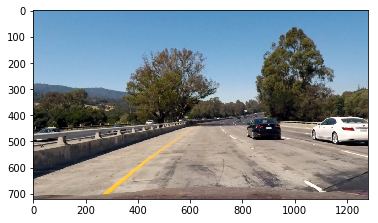

In [2]:
test_undist_img('../test_images/test1.jpg', '../output_images/road_transformed.jpg')


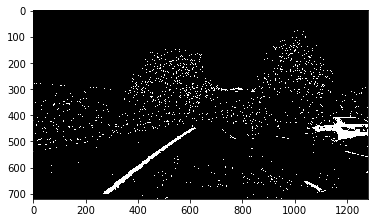

In [3]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def lhs_color_threshold(img, thresh=(140, 255)):
    # get HLS channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]        
    # apply threshold to S channel
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # Return the binary image
    return binary

def rgb_color_threshold(image, thresh=(180, 180, 120)):
    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    binary = np.zeros_like(image[:,:,2])

    red_threshold = thresh[0]
    green_threshold = thresh[1]
    blue_threshold = thresh[2]

    binary[(image[:,:,0] >= red_threshold) & (image[:,:,1] >= green_threshold) & (image[:,:,2] >= blue_threshold)] = 1

    return binary

def grad_threshold(gray):
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(gradx, sobel_kernel=3, mag_thresh=(100, 150))
    #dir_binary = dir_threshold(gradx, sobel_kernel=3, thresh=(0.0, 0.7))
    return mag_binary

def combo_threshold(path):
    undistorted_img = undist_img(path)
    gray_undistorted = cv2.cvtColor(np.copy(undistorted_img), cv2.COLOR_RGB2GRAY)
    grad_binary = grad_threshold(gray_undistorted)
    color_undistorted = np.copy(undistorted_img)
    lhs_color_binary = lhs_color_threshold(color_undistorted, thresh=(100, 255))
    #lhs_color_binary = 1
    rgb_color_binary = rgb_color_threshold(color_undistorted, thresh=(180, 180, 0))
    #rgb_color_binary = 1
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | ((lhs_color_binary == 1) & (rgb_color_binary == 1))] = 1
    #combined_binary[(grad_binary == 1)] = 1
    return combined_binary

def combo_threshold_for_img(img):
    undistorted_img = undist_img_for_img(img)
    gray_undistorted = cv2.cvtColor(np.copy(undistorted_img), cv2.COLOR_RGB2GRAY)
    grad_binary = grad_threshold(gray_undistorted)
    color_undistorted = np.copy(undistorted_img)
    lhs_color_binary = lhs_color_threshold(color_undistorted, thresh=(100, 255))
    rgb_color_binary = rgb_color_threshold(color_undistorted, thresh=(180, 180, 0))
    #rgb_color_binary = 1
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | ((lhs_color_binary == 1) & (rgb_color_binary == 1))] = 1
    #combined_binary[(grad_binary == 1)] = 1
    return combined_binary

def test_combo_threshold(in_path, out_path):
    result_binary = combo_threshold(in_path)
    plt.imshow(result_binary, cmap='gray')
    cv2.imwrite(out_path, np.uint8(255*result_binary))
    
test_combo_threshold('../test_images/test1.jpg', '../output_images/binary_combo.jpg')


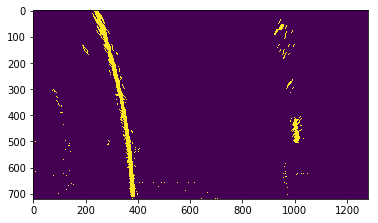

In [4]:
def warper(img, src, dst):
    M = cv2.getPerspectiveTransform(src,dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)
    return warped, M
    
def get_warp_src_dst():
    path = '../test_images/test1.jpg'
    img = mpimg.imread(path)
    img_binary = combo_threshold(path)
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    return src, dst
    
g_src, g_dst = get_warp_src_dst()

def warp_img(path):
    global g_src
    global g_dst
    binary_img = combo_threshold(path)
    warped_img, M = warper(binary_img, g_src, g_dst)
    return warped_img

def warp_img_for_img(img):
    global g_src
    global g_dst
    binary_img = combo_threshold_for_img(img)
    warped_img, M = warper(binary_img, g_src, g_dst)
    return warped_img

def unwarp_img(warped_img):
    global g_src
    global g_dst
    unwarped_img, M = warper(warped_img, g_dst, g_src)
    return unwarped_img

def test_warp_img(in_path, out_path):    
    warped_img = warp_img(in_path)
    plt.imshow(warped_img)
    cv2.imwrite(out_path, np.uint8(255*warped_img))

test_warp_img('../test_images/test2.jpg', '../output_images/warp_straight_lines.jpg')



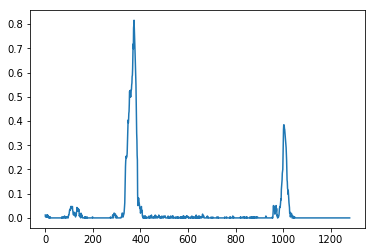

In [5]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

def test_hist(path):    
    img = mpimg.imread(path)
    hist_img = hist(warp_img(path)/255)
    plt.plot(hist_img)
    
test_hist('../test_images/test2.jpg')

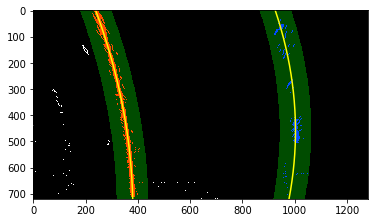

In [6]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#g_left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#g_right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
g_left_fit = np.array([0, 0, 0])
g_right_fit = np.array([0, 0, 0])
g_prev_left_fit = np.array([0, 0, 0])
g_prev_right_fit = np.array([0, 0, 0])
g_margin = 60
g_width = 0
g_leftx_base = 0
g_search_inited = False
g_ym_per_pix = 30/720 # meters per pixel in y dimension
g_xm_per_pix = 3.7/700 # meters per pixel in x dimension


def find_left_right_with_rough_width(histogram, base_width, curr_left):
    section = 20
    scan_count = 23
    section_width = int(histogram.shape[0] / section)
    lane_section_count = int(base_width / section_width)
    #start_left = int(curr_left / section_width)
    start_left = 0
    if (start_left < 0):
        start_left = 0
    start_right = start_left + lane_section_count
    max_sum = 0
    max_left = 0
    max_right = 0
    while start_left <= curr_left + scan_count / 2 and start_right + 1 < section:
        left_base = np.argmax(histogram[start_left * section_width : (start_left + 1) * section_width]) + start_left * section_width
        right_base = np.argmax(histogram[start_right * section_width : (start_right + 1) * section_width]) + start_right * section_width
        if histogram[left_base] + histogram[right_base] > max_sum:
            max_sum = histogram[left_base] + histogram[right_base]
            max_left = left_base
            max_right = right_base
        start_left = start_left + 1
        start_right = start_right + 1
    return max_left, max_right
    
def get_nonzero_pixels(binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

def find_lane_pixels(binary_warped, nwindows, margin, minpix, width, prev_leftx_base):
    global g_width
    global g_leftx_base
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    if width == 0:
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        g_width = (rightx_base - leftx_base)
        g_leftx_base = leftx_base
    else:
        #leftx_base = np.argmax(histogram[:midpoint])
        #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        tmp_start = max(0, prev_leftx_base - 300)
        #tmp_start = 0
        #tmp_end = min(prev_leftx_base + 50, min(midpoint, histogram.shape[0] - width))
        tmp_end = min(prev_leftx_base + 300, histogram.shape[0] - width)
        #tmp_end = histogram.shape[0] - width
        combo_histogram = [histogram[x] + histogram[x + width] for x in range(tmp_start, tmp_end)]
        leftx_base = np.argmax(combo_histogram)
        rightx_base = leftx_base + width
        g_leftx_base = leftx_base
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzerox, nonzeroy = get_nonzero_pixels(binary_warped)
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
        

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    
    if len(leftx) == 0 and len(rightx) > 0:
        leftx = np.array([x - width for x in rightx])
        lefty = np.array([y for y in righty])
    elif len(rightx) == 0 and len(leftx) > 0:
        rightx = np.array([x + width for x in leftx])
        righty = np.array([y for y in lefty])
        
    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_cr = np.polyfit(lefty*g_ym_per_pix, leftx*g_xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*g_ym_per_pix, rightx*g_xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit_cr, right_fit_cr


def stack_search(binary_warped, nwindows = 9, margin = 100, minpix = 100):
    # Find our lane pixels first
    global g_width
    global g_leftx_base
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows, margin, minpix, g_width, g_leftx_base)
    return fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
def get_left_right_lane_inds(binary_warped, left_fit, right_fit, margin):
    # Grab activated pixels
    nonzerox, nonzeroy = get_nonzero_pixels(binary_warped)

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    return nonzerox, nonzeroy, left_lane_inds, right_lane_inds
    
def continuous_frame_search(binary_warped, left_fit, right_fit, margin): 
    nonzerox, nonzeroy, left_lane_inds, right_lane_inds = get_left_right_lane_inds(binary_warped, left_fit, right_fit, margin)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    return fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
def generic_search(binary_warped):
    global g_left_fit
    global g_right_fit
    global g_margin
    global g_search_inited
    global g_width
    if not g_search_inited:
        left_fitx, right_fitx, ploty, g_left_fit, g_right_fit, left_fit_cr, right_fit_cr = stack_search(binary_warped, nwindows = 9, margin = g_margin, minpix = 50)
        g_search_inited = True
    else:
        left_fitx, right_fitx, ploty, g_left_fit, g_right_fit, left_fit_cr, right_fit_cr = continuous_frame_search(binary_warped, g_left_fit, g_right_fit, g_margin / 2)
        if (right_fitx[-1] - left_fitx[-1] < g_width / 2):
            g_search_inited = False
            g_width = 0
            left_fitx, right_fitx, ploty, g_left_fit, g_right_fit, left_fit_cr, right_fit_cr = stack_search(binary_warped, nwindows = 9, margin = g_margin, minpix = 50)
            g_search_inited = True
    return left_fitx, right_fitx, ploty, g_left_fit, g_right_fit, left_fit_cr, right_fit_cr

def visualize_fit_lanes(binary_warped, left_fitx, right_fitx, ploty):

    nonzerox, nonzeroy, left_lane_inds, right_lane_inds = get_left_right_lane_inds(binary_warped, g_left_fit, g_right_fit, g_margin)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-g_margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+g_margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-g_margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+g_margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result    

def show_center_line(left_fitx, right_fitx, ploty):    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
def test_fit_lanes(in_path, out_path):
    binary_warped = warp_img(in_path)
    left_fitx, right_fitx, ploty, dummy_left_fit, dummy_right_fit, left_fit_cr, right_fit_cr = generic_search(binary_warped)
    warped_lanes = visualize_fit_lanes(binary_warped, left_fitx, right_fitx, ploty)
    cv2.imwrite(out_path, warped_lanes)
    show_center_line(left_fitx, right_fitx, ploty)
    plt.imshow(warped_lanes)
    
test_fit_lanes('../test_images/test2.jpg', '../output_images/fit_visual.jpg')


In [7]:

def calc_curvature_m(fit, y_eval):
        return ((1 + (2*fit[0]*y_eval*g_ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    
def measure_curvature_pixels(path):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    binary_warped = warp_img(path)
    
    global g_search_inited
    
    left_fitx, right_fitx, ploty, left_fit, right_fit, left_fit_cr, right_fit_cr = generic_search(binary_warped)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    if left_fitx[0] == 0:
        left_curverad = 3e+14
    else:
        left_curverad = calc_curvature_m(left_fit_cr, y_eval)
    if right_fitx[0] == 0:
        right_curverad = 3e+14
    else:
        right_curverad = calc_curvature_m(right_fit_cr, y_eval)
    
    return left_curverad, right_curverad


def test_measure_curvature_pixels(path):
    left_curverad, right_curverad = measure_curvature_pixels(path)
    print(left_curverad, right_curverad)
    
test_measure_curvature_pixels('../test_images/test2.jpg')


690.912980792 473.721398312


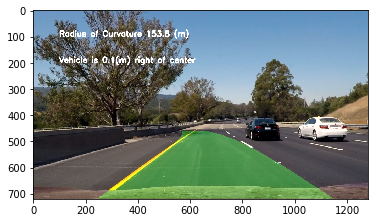

In [8]:
def combine_fit_and_undist_image(undist_img, warped, left_fitx, right_fitx, ploty, curverad, center_shift):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    cv2.putText(undist_img,"Radius of Curvature {:.1f} (m)".format(curverad), (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3, cv2.LINE_AA)
    if (center_shift > 0):
        cv2.putText(undist_img,"Vehicle is {:.1f}(m) right of center".format(center_shift), (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3, cv2.LINE_AA)
    else:
        cv2.putText(undist_img,"Vehicle is {:.1f}(m) left of center".format(-center_shift), (100, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3, cv2.LINE_AA)        

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = unwarp_img(color_warp) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    return result

def calc_center_shift(left_fitx, right_fitx, width):
    center_x = (left_fitx[-1] + right_fitx[-1]) / 2
    delta_x = center_x - width / 2
    return delta_x * g_xm_per_pix

def process_image(img):
    binary_warped = warp_img_for_img(img)
    left_fitx, right_fitx, ploty, dummy_left_fit, dummy_right_fit, left_fit_cr, right_fit_cr = generic_search(binary_warped)
    curverad = calc_curvature_m(right_fit_cr, np.max(ploty))
    center_shift = calc_center_shift(left_fitx, right_fitx, img.shape[1])
    combined_img = combine_fit_and_undist_image(img, binary_warped, left_fitx, right_fitx, ploty, curverad, center_shift)
    return combined_img
    
g_width = 0
def test_process_image(in_path, out_path):
    global g_prev_left_fit
    global g_prev_right_fit
    g_prev_left_fit = np.array([0, 0, 0])
    g_prev_right_fit = np.array([0, 0, 0])
    img = mpimg.imread(in_path)
    example_output = process_image(img)
    plt.imshow(example_output)
    cv2.imwrite(out_path, example_output)
    
test_process_image('../test_images/test6.jpg', '../output_images/example_output.jpg')

In [9]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [10]:
g_search_inited = False
g_width = 0
video_output = '../output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_images/project_video_output.mp4
[MoviePy] Writing video ../output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [05:43<00:00,  3.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/project_video_output.mp4 

CPU times: user 3min 29s, sys: 2.43 s, total: 3min 32s
Wall time: 5min 46s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [12]:
g_search_inited = False
g_width = 0
video_output = '../output_images/challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_images/challenge_video_output.mp4
[MoviePy] Writing video ../output_images/challenge_video_output.mp4


100%|██████████| 485/485 [02:14<00:00,  3.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/challenge_video_output.mp4 

CPU times: user 1min 16s, sys: 10.1 s, total: 1min 26s
Wall time: 2min 17s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [14]:
g_search_inited = False
g_width = 0
video_output = '../output_images/harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../output_images/harder_challenge_video_output.mp4
[MoviePy] Writing video ../output_images/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [06:40<00:00,  3.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/harder_challenge_video_output.mp4 

CPU times: user 3min 28s, sys: 36.3 s, total: 4min 4s
Wall time: 6min 44s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))